<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Анализ результатов</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import datetime as DT
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## Анализ

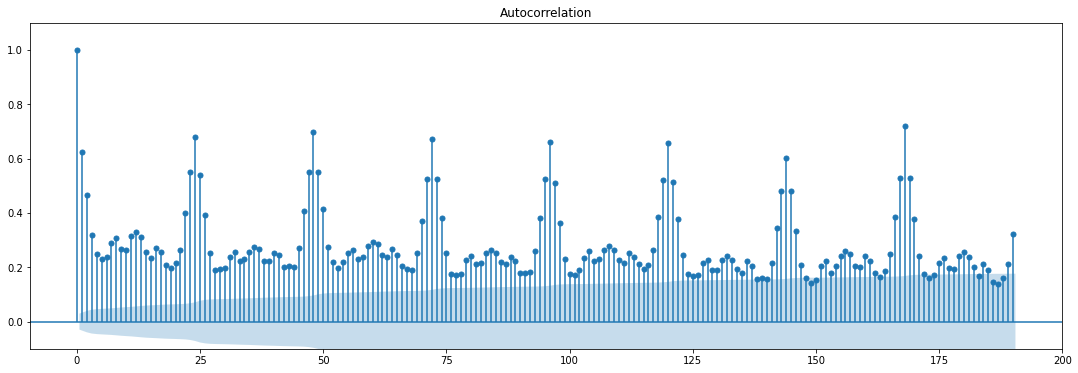

In [5]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


In [6]:
decomposed = seasonal_decompose(taxi)

Text(0.5, 1.0, 'Тренд')

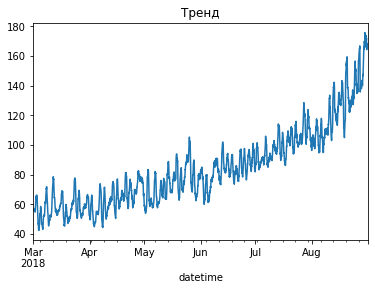

In [7]:
decomposed.trend.plot()
plt.title("Тренд")

<br/>
<div class="alert alert-info">
Плавное увеличение количества заказов от марта до августа, есть небольшие спады.
</div>

Text(0.5, 1.0, 'Сезонность')

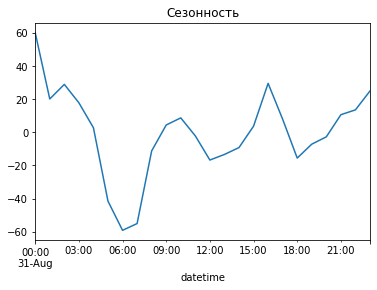

In [8]:
decomposed.seasonal.tail(24).plot()
plt.title("Сезонность")

<br/>
<div class="alert alert-info">
Рост заказов с утра и пик заказов вечером
</div>

Text(0.5, 1.0, 'Шум')

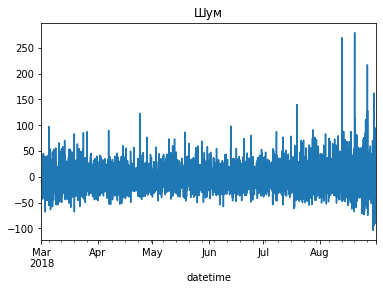

In [9]:
decomposed.resid.plot()
plt.title("Шум")

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    
    return data

In [11]:
final_data = make_features(taxi, 24, 8)

In [12]:
final_data

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,62.875
2018-03-02 01:00:00,120,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,68.750
2018-03-02 02:00:00,75,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,78.250
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,78.500
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,80.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,167.375
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,163.500
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,165.750


In [13]:
features = final_data.drop(['num_orders'], axis=1)

In [14]:
target = final_data['num_orders']

## Обучение

In [15]:
features_train, features_test, target_train, target_test  = train_test_split(features, target, 
                                                                            test_size = 0.1,shuffle=False, random_state=12345)

### Catboost

In [16]:
catboost = CatBoostClassifier()
params_cat = {'learning_rate': [0.03, 0.1, 0.2],
        'depth': [4, 6, 10]}
scorer = 'neg_root_mean_squared_error'

In [17]:
tscv = TimeSeriesSplit(n_splits=5)
gsearch_cat = GridSearchCV(estimator=catboost, cv=tscv, param_grid=params_cat)
gsearch_cat.fit(features_train,target_train)

0:	learn: 29.2917942	total: 48ms	remaining: 48s
1:	learn: 28.8936204	total: 49.8ms	remaining: 24.8s
2:	learn: 28.5195378	total: 51.2ms	remaining: 17s
3:	learn: 28.1508777	total: 52.8ms	remaining: 13.1s
4:	learn: 27.7992997	total: 54.1ms	remaining: 10.8s
5:	learn: 27.4737398	total: 55.6ms	remaining: 9.21s
6:	learn: 27.1650443	total: 56.9ms	remaining: 8.08s
7:	learn: 26.8040908	total: 58.4ms	remaining: 7.24s
8:	learn: 26.5015288	total: 59.8ms	remaining: 6.59s
9:	learn: 26.2111148	total: 61.1ms	remaining: 6.05s
10:	learn: 25.9607718	total: 62.4ms	remaining: 5.61s
11:	learn: 25.6955034	total: 63.7ms	remaining: 5.24s
12:	learn: 25.4524330	total: 65.1ms	remaining: 4.94s
13:	learn: 25.2059456	total: 66.5ms	remaining: 4.68s
14:	learn: 24.9865811	total: 67.7ms	remaining: 4.45s
15:	learn: 24.7674710	total: 69.2ms	remaining: 4.26s
16:	learn: 24.5419564	total: 70.5ms	remaining: 4.07s
17:	learn: 24.3393985	total: 71.8ms	remaining: 3.92s
18:	learn: 24.1174905	total: 73.5ms	remaining: 3.8s
19:	learn:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f4540d8f910>,
             param_grid={'depth': [4, 6, 10],
                         'learning_rate': [0.03, 0.1, 0.2]})

In [18]:
gsearch_cat.best_params_

{'depth': 6, 'learning_rate': 0.03}

In [19]:
predictions = gsearch_cat.predict(features_train)
rmse_catboost = mean_squared_error(target_train, predictions, squared=False)

### LinearRegression

In [20]:
model_lin = LinearRegression()

In [21]:
model_lin.fit(features_train, target_train)

LinearRegression()

In [22]:
predictions = model_lin.predict(features_train)
rmse_lin = mean_squared_error(target_train, predictions, squared=False)

### Random Forest

In [23]:
rf = RandomForestRegressor()
params_rf = {'n_estimators':[10, 50,100], 'max_depth':[1,5,10]}


In [24]:
gsearch_rf = GridSearchCV(estimator=catboost, cv=tscv, param_grid=params_rf)
gsearch_rf.fit(features_train,target_train)

Learning rate set to 0.5
0:	learn: 26.4395473	total: 448us	remaining: 4.03ms
1:	learn: 24.2819600	total: 875us	remaining: 3.5ms
2:	learn: 22.7405791	total: 1.23ms	remaining: 2.87ms
3:	learn: 21.7919045	total: 1.61ms	remaining: 2.42ms
4:	learn: 21.2120955	total: 1.98ms	remaining: 1.98ms
5:	learn: 20.7065434	total: 2.28ms	remaining: 1.52ms
6:	learn: 20.3821151	total: 2.64ms	remaining: 1.13ms
7:	learn: 20.1465265	total: 3.01ms	remaining: 752us
8:	learn: 19.8903629	total: 3.36ms	remaining: 373us
9:	learn: 19.6812986	total: 3.66ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 27.1286646	total: 611us	remaining: 5.51ms
1:	learn: 25.5030152	total: 1.27ms	remaining: 5.08ms
2:	learn: 24.3058521	total: 1.92ms	remaining: 4.49ms
3:	learn: 23.3306743	total: 2.53ms	remaining: 3.8ms
4:	learn: 22.7406471	total: 3.29ms	remaining: 3.29ms
5:	learn: 22.3348226	total: 3.9ms	remaining: 2.6ms
6:	learn: 21.9611480	total: 4.47ms	remaining: 1.91ms
7:	learn: 21.7134018	total: 5.02ms	remaining: 1.25ms
8:	learn

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f4540d8f910>,
             param_grid={'max_depth': [1, 5, 10],
                         'n_estimators': [10, 50, 100]})

In [25]:
gsearch_rf.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [26]:
predictions = gsearch_rf.predict(features_train)
rmse_rf = mean_squared_error(target_train, predictions, squared=False)

### Анализ результатов

In [27]:
result_train = []
result_train.append(["Catboost", rmse_catboost])
result_train.append(["Lin. Reg.", rmse_lin])
result_train.append(["RF", rmse_rf])
result_train = pd.DataFrame(result_train, columns=["Model","RMSE"])
result_train = result_train.set_index('Model')

In [28]:
result_train

,RMSE
Model,
Catboost,14.275662
Lin. Reg.,25.844766
RF,15.836466


## Тестирование

In [29]:
pred = gsearch_cat.predict(features_test) 
rmse_cat_test = mean_squared_error(target_test, pred, squared=False)

In [30]:
pred = model_lin.predict(features_test) 
rmse_lin_test = mean_squared_error(target_test, pred, squared=False)

In [31]:
pred = gsearch_rf.predict(features_test) 
rmse_rf_test = mean_squared_error(target_test, pred, squared=False)

In [32]:
result_test = []
result_test.append(["Catboost", rmse_cat_test])
result_test.append(["Lin. Reg.", rmse_lin_test])
result_test.append(["RF", rmse_rf_test])
result_test= pd.DataFrame(result_test, columns=["Model","RMSE_Test"])
result_test = result_test.set_index('Model')

In [33]:
result_test

,RMSE_Test
Model,
Catboost,40.402411
Lin. Reg.,45.224095
RF,41.428900


In [34]:
gsearch_cat.best_params_

{'depth': 6, 'learning_rate': 0.03}

<br/>
<div class="alert alert-info">
Лучший результат показала модель Catboost. RMSE - 40.40, параметры модели - 'depth': 6, 'learning_rate': 0.03
</div>